# leptonjet composition

To split leptonjet into *egamma type* and *muon-type*, we need to see how reasonable to do the splitting by multiplicity.

The idea is:

For short decay-length darkphoton:
- $\gamma\prime\rightarrow\mu^+\mu^-$ would give mostly a pair of **PFMuon**
- $\gamma\prime\rightarrow e^+e^-$ would give mostly a pair of **PFElectron** or photon

For long decay-length darkphoton:
- $\gamma\prime\rightarrow\mu^+\mu^-$ would give mostly a pair of **dSAMuon**
- $\gamma\prime\rightarrow e^+e^-$ would give mostly photons


If above assumption holds, we see again at _event level_, if we lost anything by
- 4mu channel, requiring leading two are muon-type
- 2mu2e channel, requiring leading two are one muon-type and one electron type
- and if requiring exactly two leptonjets making sense

If above assumptions holds, no big issues showed up,
- how scaled backgrouds changes accordingly
- how tighten dSA muon quality would impact signals, both efficiency and resolution.

At last, implement above changes, reload data in control region, compare the shape again.

## actions
find currently matched leptonjets, if matched to dpToMuMu/dpToEE, count muon multiplicity, count dSA multiplicity, count electron multiplicity, count photon multiplicity.

After deciding upon muon-type/electron-type criteria, counting event-level multiplicities

then inspect backgrounds.

In [1]:
from coffea import hist
import coffea.processor as processor
from coffea.analysis_objects import JaggedCandidateArray
import numpy as np
import matplotlib.pyplot as plt
import awkward

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

In [3]:
class compositionProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        nummuon_axis = hist.Bin('nmu', '# muons in leptonjets', 5, 0, 5)
        numdsa_axis = hist.Bin('ndsa', '# dSAs in leptonjets', 5, 0, 5)
        numel_axis = hist.Bin('nel', '# electrons in leptonjets', 5, 0, 5)
        numpho_axis = hist.Bin('npho', '# photons in leptonjets', 10, 0, 10)
        dautype_axis = hist.Cat('dautype', 'darkphoton decay to')
        self._accumulator = processor.dict_accumulator({
            'nmu': hist.Hist('Counts', dataset_axis, nummuon_axis, dautype_axis),
            'ndsa': hist.Hist('Counts', dataset_axis, numdsa_axis, dautype_axis),
            'nel': hist.Hist('Counts', dataset_axis, numel_axis, dautype_axis),
            'npho': hist.Hist('Counts', dataset_axis, numpho_axis, dautype_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        leptonjets.add_attributes(nmu=((ljdautype==3)|(ljdautype==8)).sum(),
                                  ndsa=(ljdautype==8).sum(),
                                  nel=(ljdautype==2).sum(),
                                  npho=(ljdautype==4).sum(),
                                 )
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid'],
            dpid=df['gen_daupid'],
        )
        
        dpEl = genparticles[(genparticles.pid==32)&(genparticles.dpid==11)]
        dpMu = genparticles[(genparticles.pid==32)&(genparticles.dpid==13)]
        maskMu = leptonjets.match(dpMu, deltaRCut=0.4)
        maskEl = leptonjets.match(dpEl, deltaRCut=0.4)
        
        output['nmu'].fill(dataset=dataset, dautype='$\mu^+\mu^-$',
                           nmu=leptonjets[maskMu].nmu.flatten())
        output['nmu'].fill(dataset=dataset, dautype='$e^+e^-$',
                           nmu=leptonjets[maskEl].nmu.flatten())
        output['ndsa'].fill(dataset=dataset, dautype='$\mu^+\mu^-$',
                           ndsa=leptonjets[maskMu].ndsa.flatten())
        output['ndsa'].fill(dataset=dataset, dautype='$e^+e^-$',
                           ndsa=leptonjets[maskEl].ndsa.flatten())
        output['nel'].fill(dataset=dataset, dautype='$\mu^+\mu^-$',
                           nel=leptonjets[maskMu].nel.flatten())
        output['nel'].fill(dataset=dataset, dautype='$e^+e^-$',
                           nel=leptonjets[maskEl].nel.flatten())
        output['npho'].fill(dataset=dataset, dautype='$\mu^+\mu^-$',
                           npho=leptonjets[maskMu].npho.flatten())
        output['npho'].fill(dataset=dataset, dautype='$e^+e^-$',
                           npho=leptonjets[maskEl].npho.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- lxy: 0.3cm

In [18]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=compositionProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


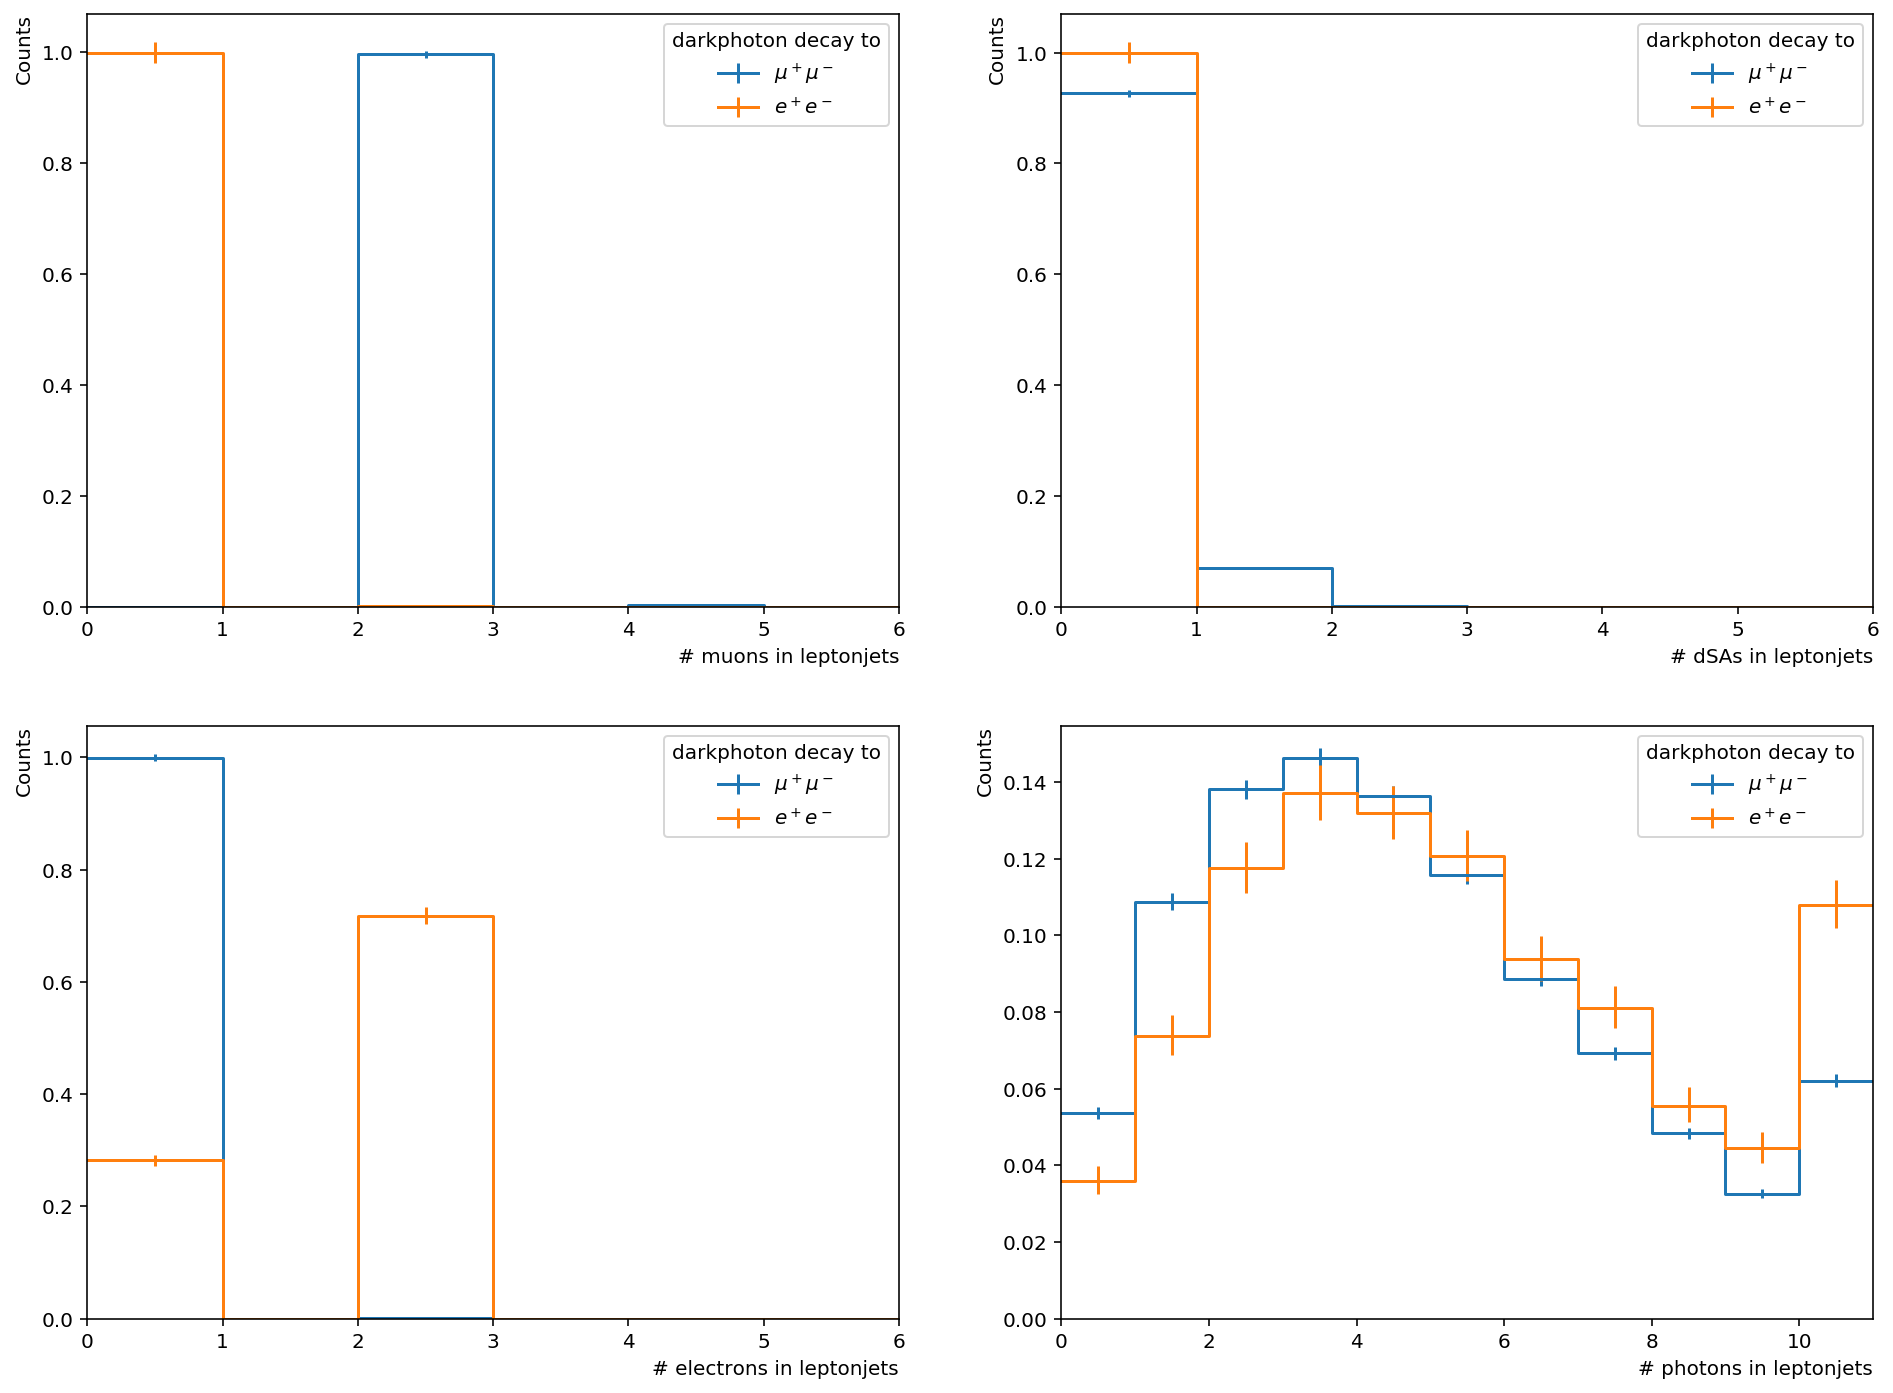

In [19]:
fig, axes = plt.subplots(2,2,figsize=(16, 12))
hist.plot1d(output['nmu'].integrate('dataset'), overlay='dautype', ax=axes[0][0], overflow='over', density=True)
hist.plot1d(output['ndsa'].integrate('dataset'), overlay='dautype', ax=axes[0][1], overflow='over', density=True)
hist.plot1d(output['nel'].integrate('dataset'), overlay='dautype', ax=axes[1][0], overflow='over', density=True)
hist.plot1d(output['npho'].integrate('dataset'), overlay='dautype', ax=axes[1][1], overflow='over', density=True)
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

- lxy: 300cm

In [20]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=compositionProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:05<00:00,  3.98items/s]


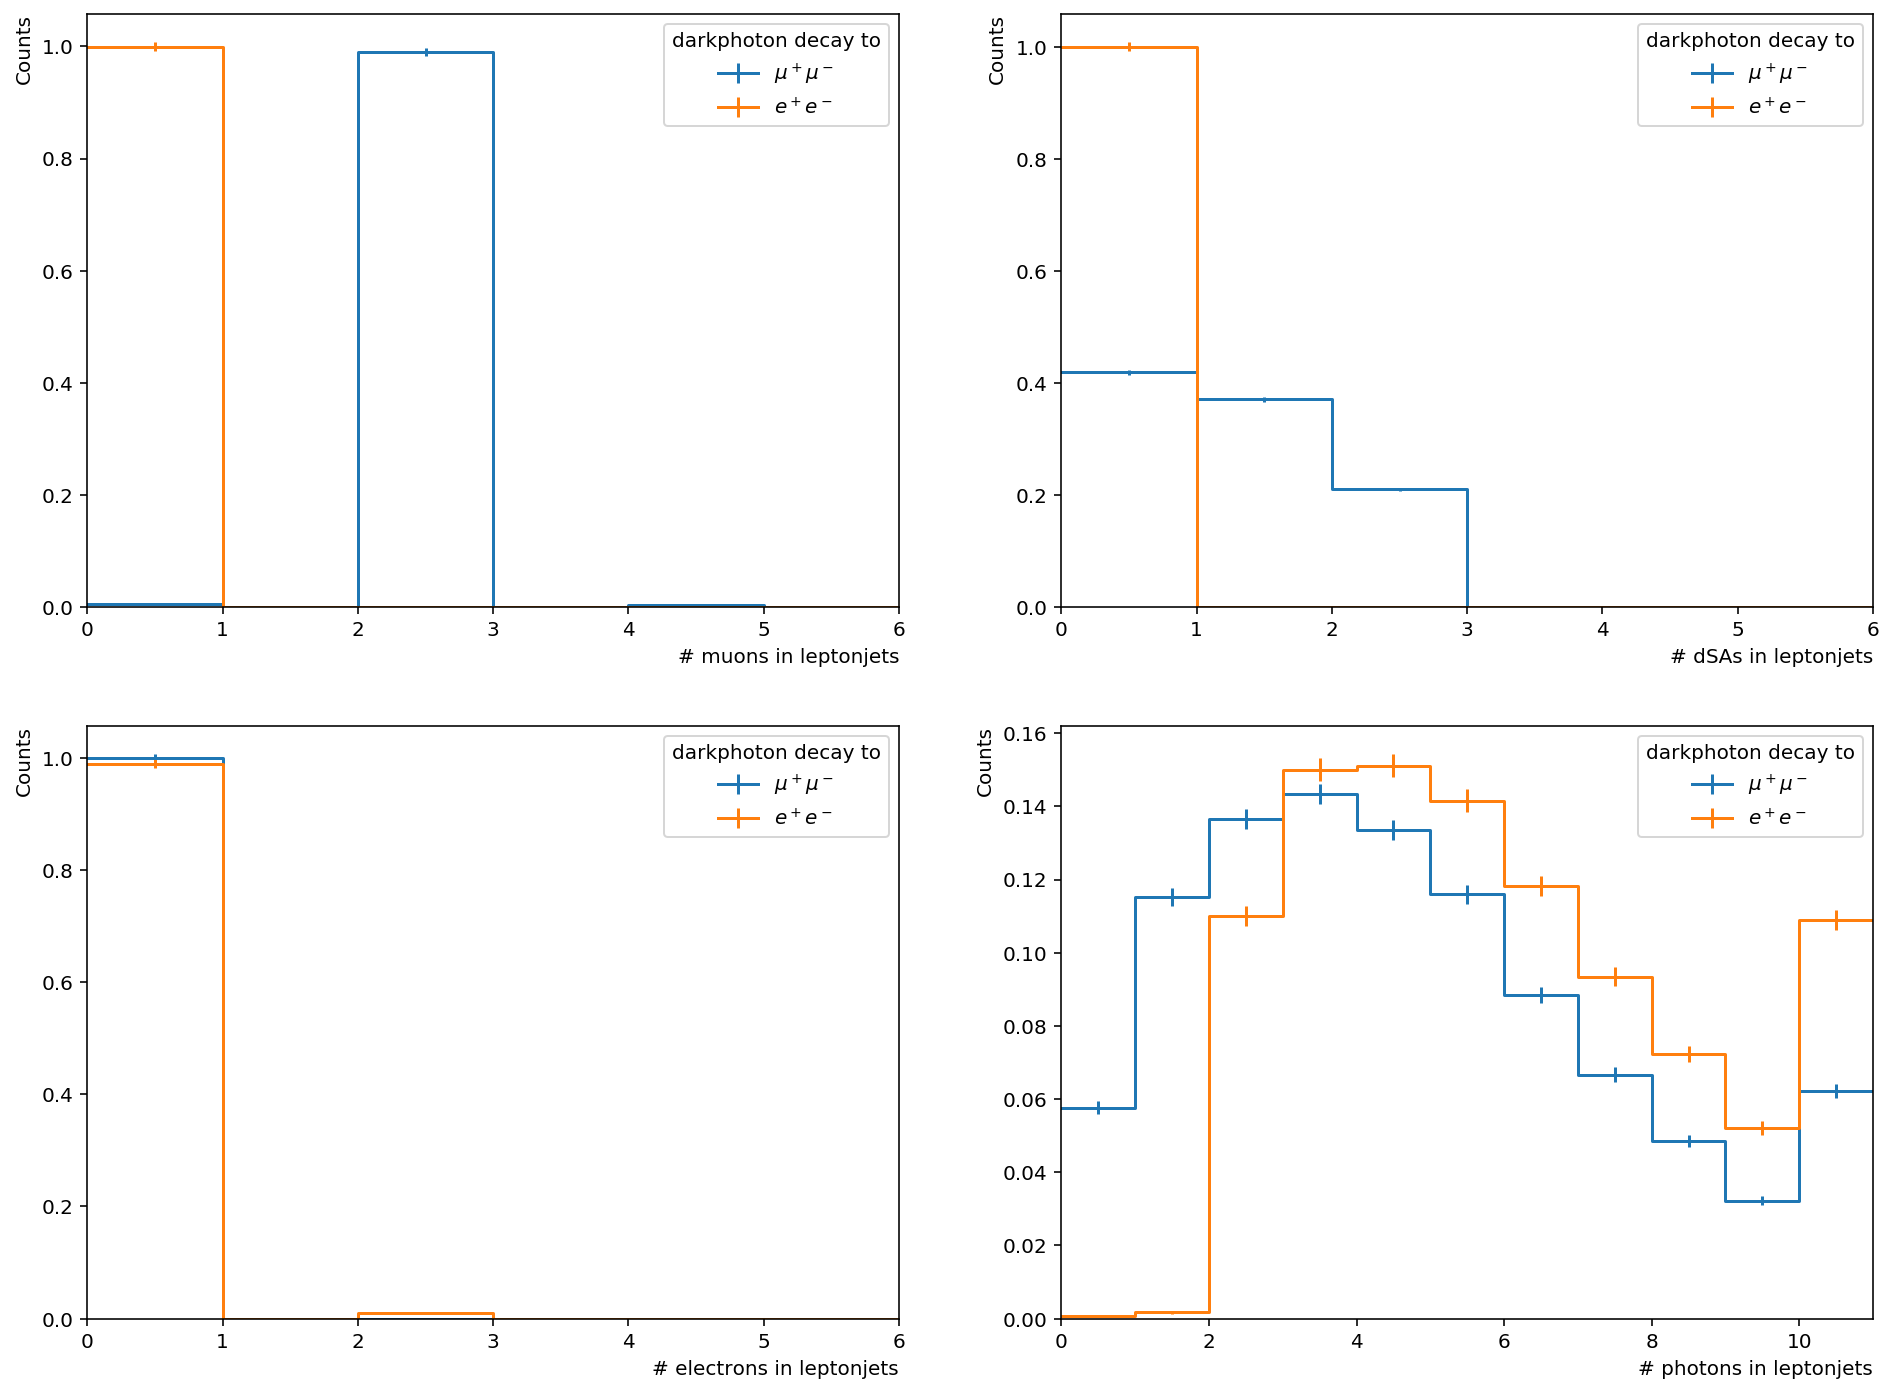

In [21]:
fig, axes = plt.subplots(2,2,figsize=(16, 12))
hist.plot1d(output['nmu'].integrate('dataset'), overlay='dautype', ax=axes[0][0], overflow='over', density=True)
hist.plot1d(output['ndsa'].integrate('dataset'), overlay='dautype', ax=axes[0][1], overflow='over', density=True)
hist.plot1d(output['nel'].integrate('dataset'), overlay='dautype', ax=axes[1][0], overflow='over', density=True)
hist.plot1d(output['npho'].integrate('dataset'), overlay='dautype', ax=axes[1][1], overflow='over', density=True)
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

In [40]:
class eventProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        mutype_axis = hist.Bin('nmulj', '# muon-type leptonjets', 5, 0, 5)
        eltype_axis = hist.Bin('nellj', '# electron-type leptonjets', 5, 0, 5)
        self._accumulator = processor.dict_accumulator({
            'nmutype': hist.Hist('Events', dataset_axis, mutype_axis),
            'neltype': hist.Hist('Events', dataset_axis, eltype_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid'],
            dpid=df['gen_daupid'],
        )
        darkphotons = genparticles[genparticles.pid==32]
        leptonjets.add_attributes(ismatched=leptonjets.match(darkphotons, deltaRCut=0.4))
        
        leptonjets = leptonjets[(leptonjets.counts>1)&(leptonjets.ismatched.sum()==2)]
        output['nmutype'].fill(dataset=dataset, nmulj=leptonjets.ismutype.sum())
        output['neltype'].fill(dataset=dataset, nellj=leptonjets.iseltype.sum())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- lxy: 0.3cm

In [41]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=eventProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


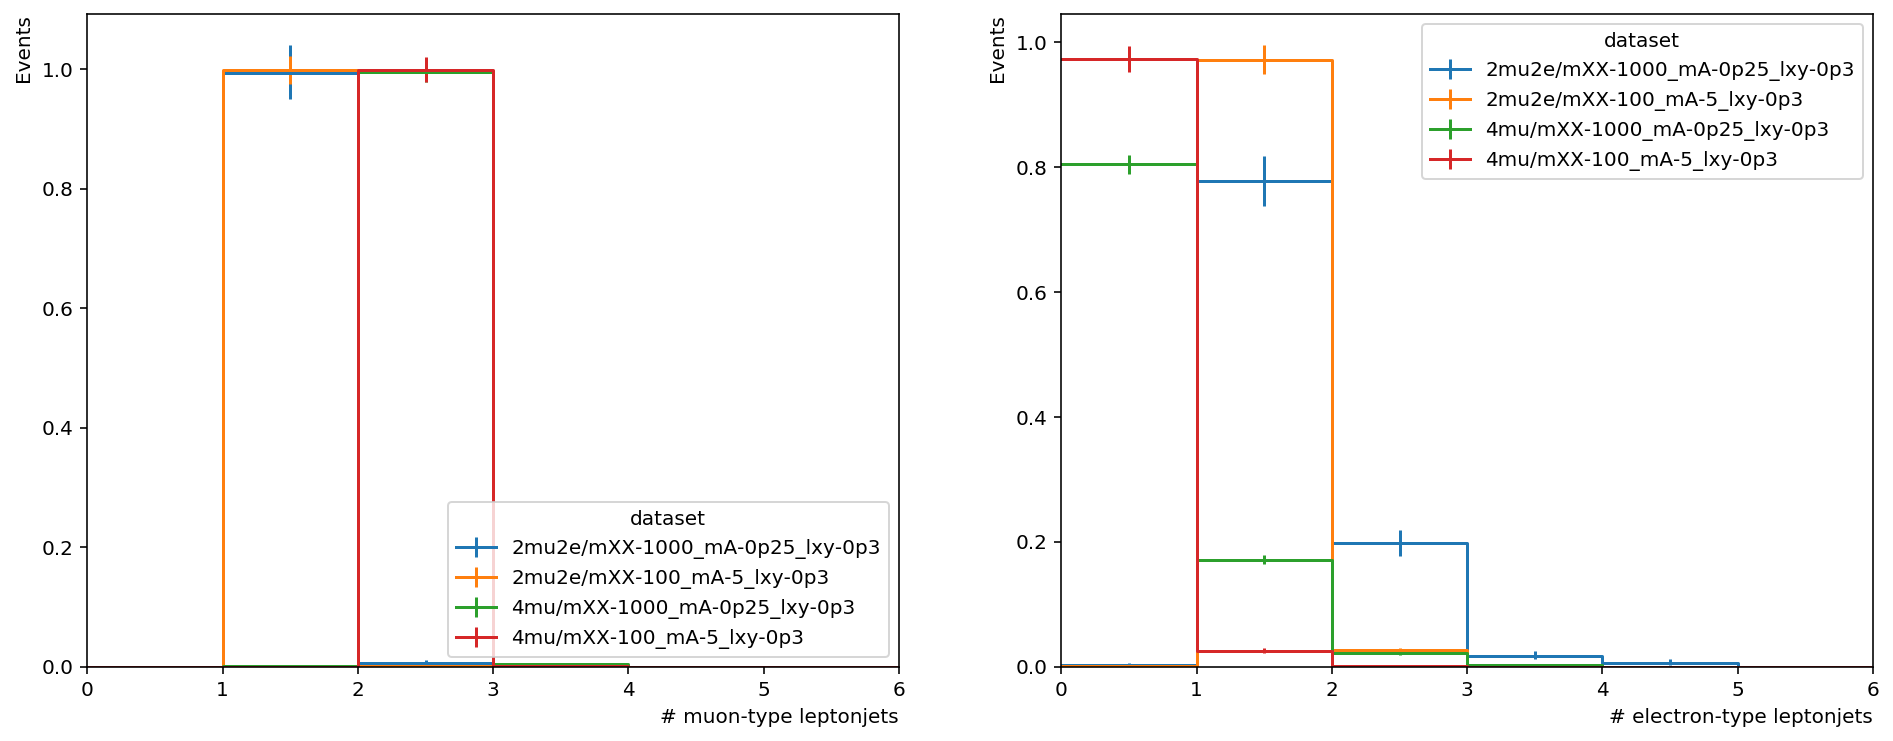

In [42]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['nmutype'], overlay='dataset', ax=axes[0], overflow='over', density=True)
hist.plot1d(output['neltype'], overlay='dataset', ax=axes[1], overflow='over', density=True)

for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

- lxy: 300cm

In [43]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=eventProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  2.13items/s]


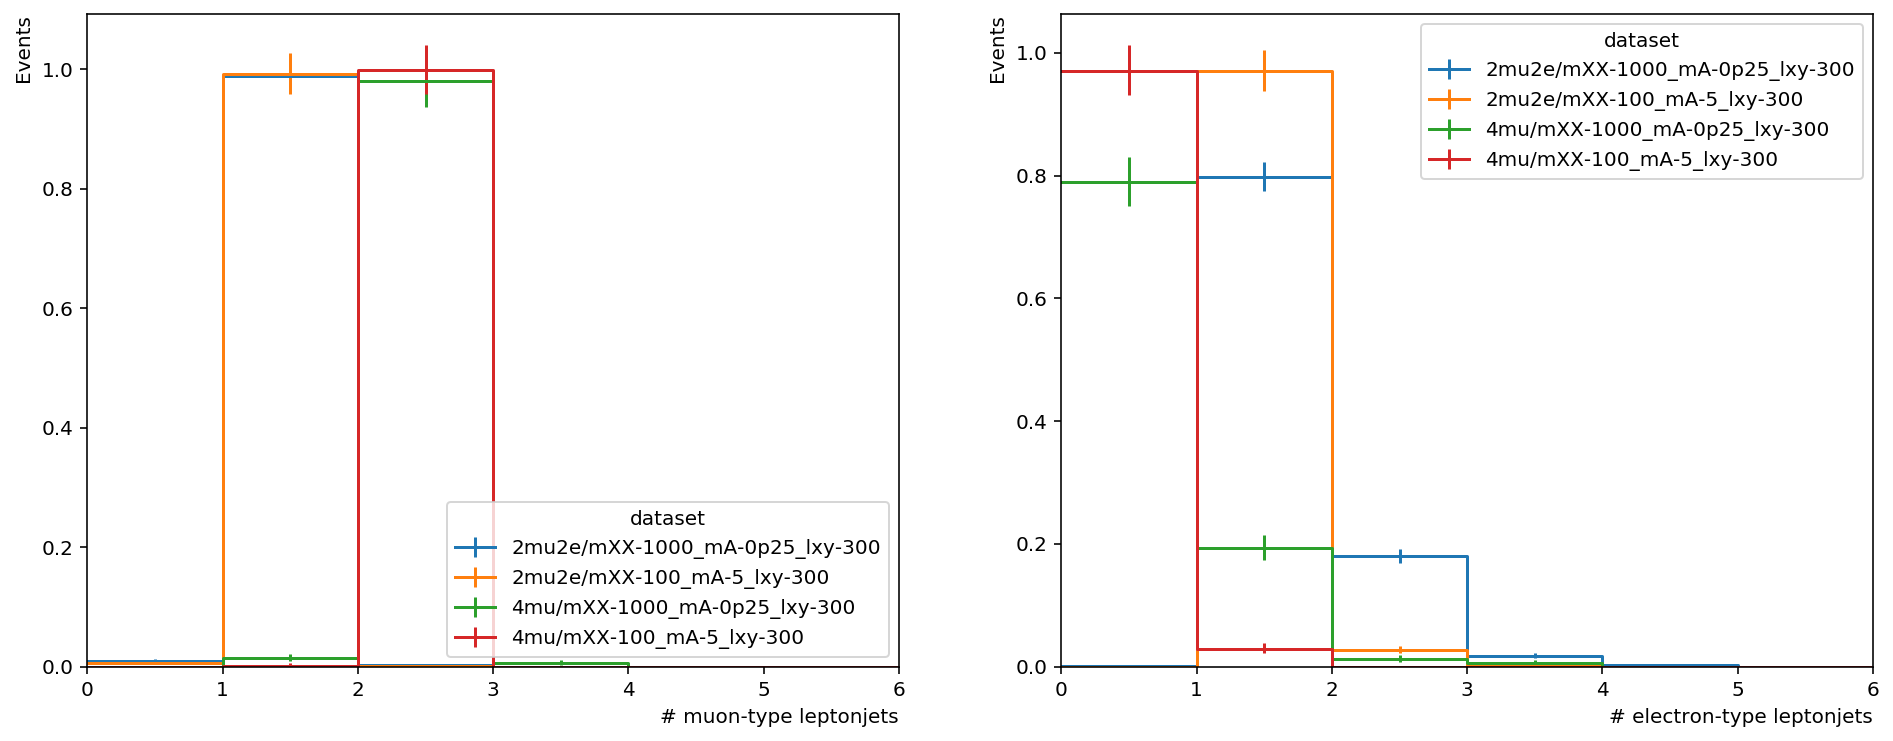

In [44]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['nmutype'], overlay='dataset', ax=axes[0], overflow='over', density=True)
hist.plot1d(output['neltype'], overlay='dataset', ax=axes[1], overflow='over', density=True)

for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

## just the leading two

In [45]:
class eventProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        mutype_axis = hist.Bin('nmulj', '# muon-type leptonjets', 5, 0, 5)
        eltype_axis = hist.Bin('nellj', '# electron-type leptonjets', 5, 0, 5)
        self._accumulator = processor.dict_accumulator({
            'nmutype': hist.Hist('Events', dataset_axis, mutype_axis),
            'neltype': hist.Hist('Events', dataset_axis, eltype_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu==2), iseltype=(nmu==0))
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid'],
            dpid=df['gen_daupid'],
        )
        darkphotons = genparticles[genparticles.pid==32]
        leptonjets.add_attributes(ismatched=leptonjets.match(darkphotons, deltaRCut=0.4))
        
        leptonjets = leptonjets[(leptonjets.counts>1)&(leptonjets.ismatched.sum()==2)]

        leadtwo = leptonjets[leptonjets.pt.argsort()[:, :2]]
        output['nmutype'].fill(dataset=dataset, nmulj=leadtwo.ismutype.sum())
        output['neltype'].fill(dataset=dataset, nellj=leadtwo.iseltype.sum())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- lxy: 0.3cm

In [46]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=eventProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


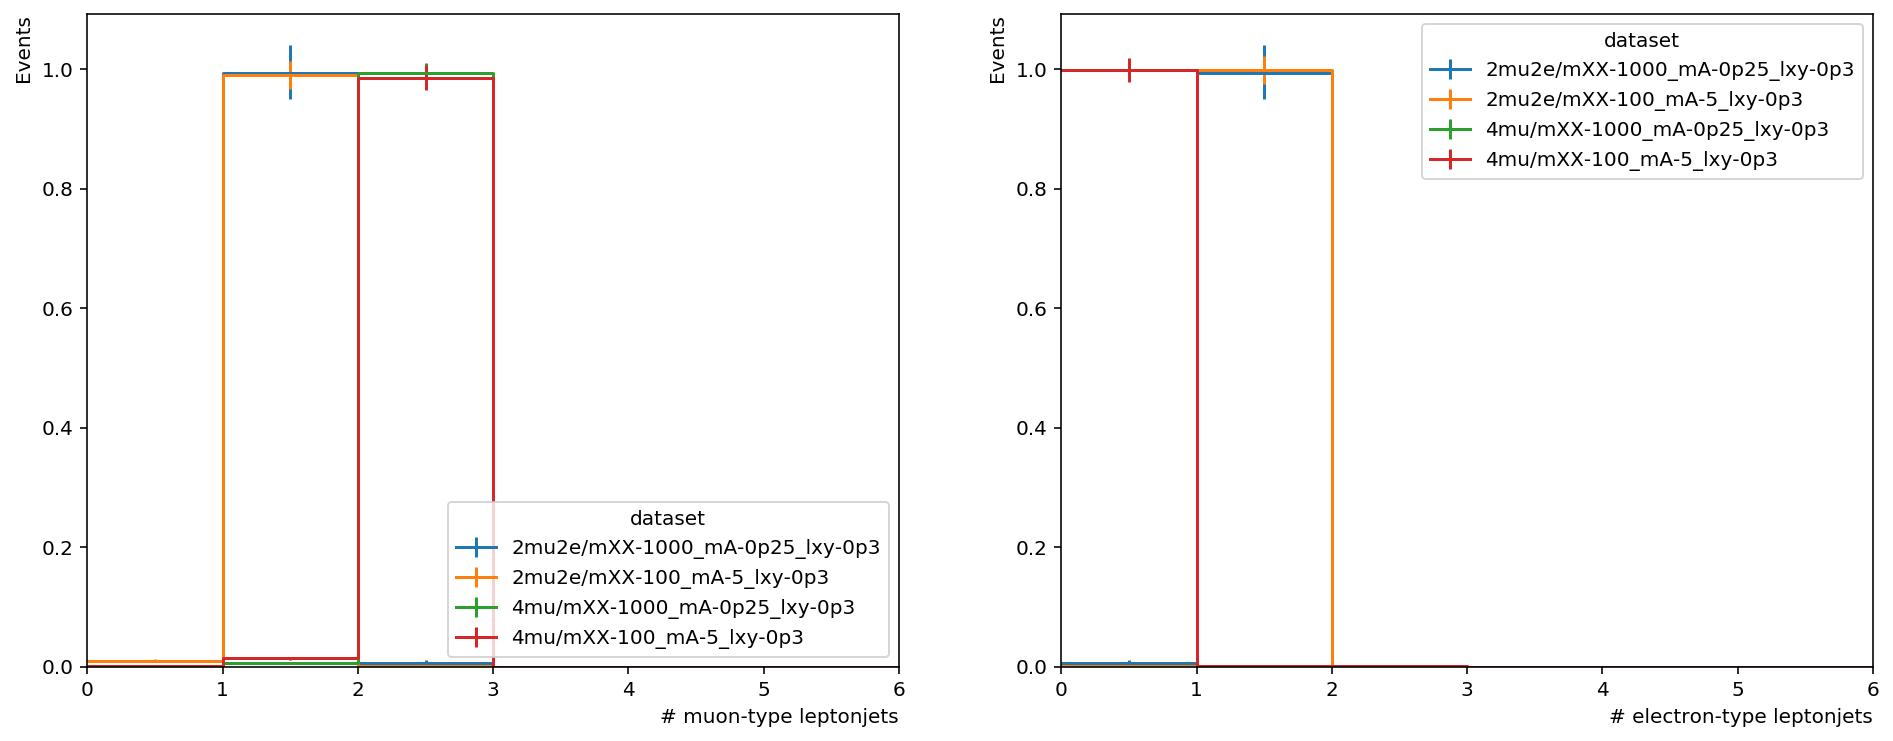

In [47]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['nmutype'], overlay='dataset', ax=axes[0], overflow='over', density=True)
hist.plot1d(output['neltype'], overlay='dataset', ax=axes[1], overflow='over', density=True)

for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

- lxy: 300cm

In [48]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=eventProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:05<00:00,  3.99items/s]


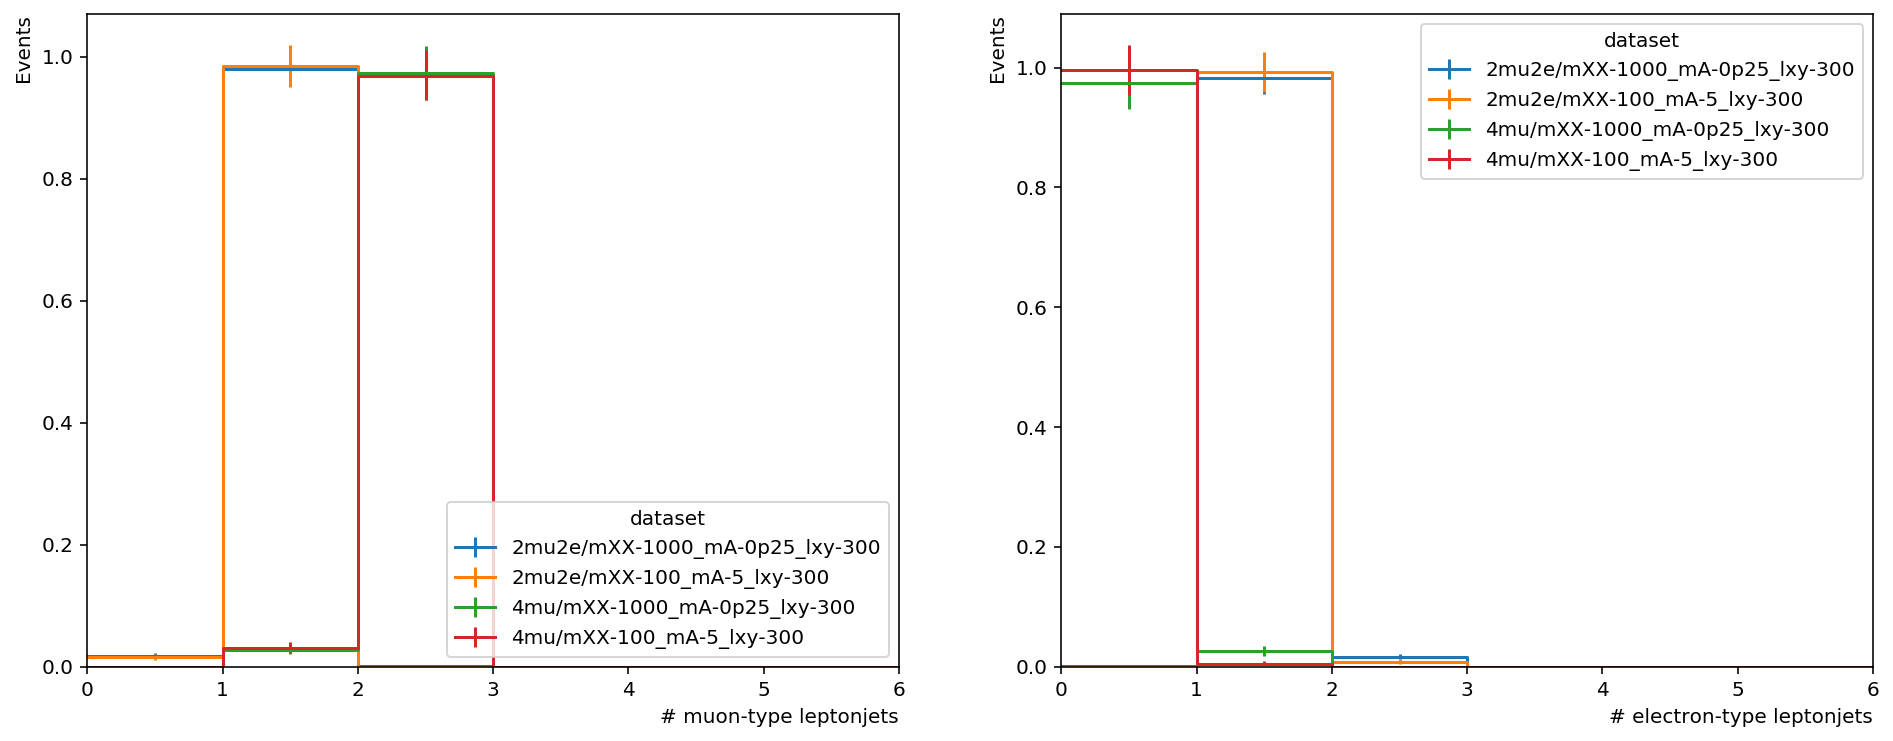

In [49]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['nmutype'], overlay='dataset', ax=axes[0], overflow='over', density=True)
hist.plot1d(output['neltype'], overlay='dataset', ax=axes[1], overflow='over', density=True)

for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

## the matched two

In [30]:
class eventProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        mutype_axis = hist.Bin('nmulj', '# muon-type leptonjets', 5, 0, 5)
        eltype_axis = hist.Bin('nellj', '# electron-type leptonjets', 5, 0, 5)
        self._accumulator = processor.dict_accumulator({
            'nmutype': hist.Hist('Events', dataset_axis, mutype_axis),
            'neltype': hist.Hist('Events', dataset_axis, eltype_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid'],
            dpid=df['gen_daupid'],
        )
        darkphotons = genparticles[genparticles.pid==32]
        leptonjets.add_attributes(ismatched=leptonjets.match(darkphotons, deltaRCut=0.4))
        
        leptonjets = leptonjets[leptonjets.ismatched]
        bothmatched = leptonjets[leptonjets.counts==2]
        output['nmutype'].fill(dataset=dataset, nmulj=bothmatched.ismutype.sum())
        output['neltype'].fill(dataset=dataset, nellj=bothmatched.iseltype.sum())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- lxy: 0.3cm

In [31]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=eventProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


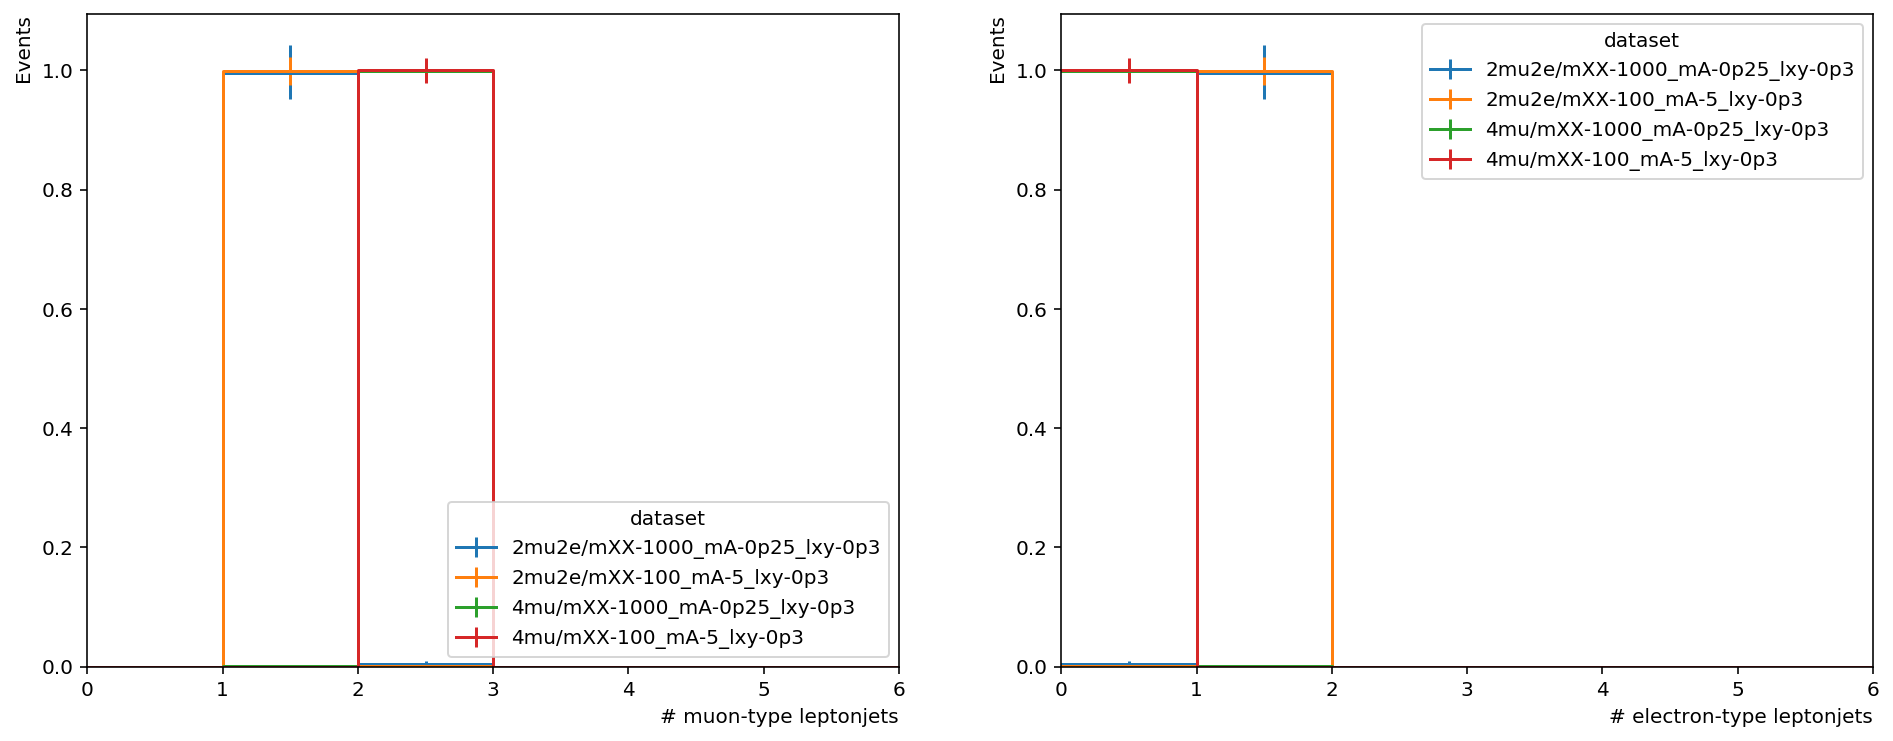

In [32]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['nmutype'], overlay='dataset', ax=axes[0], overflow='over', density=True)
hist.plot1d(output['neltype'], overlay='dataset', ax=axes[1], overflow='over', density=True)

for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

- lxy: 300cm

In [33]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=eventProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  2.15items/s]


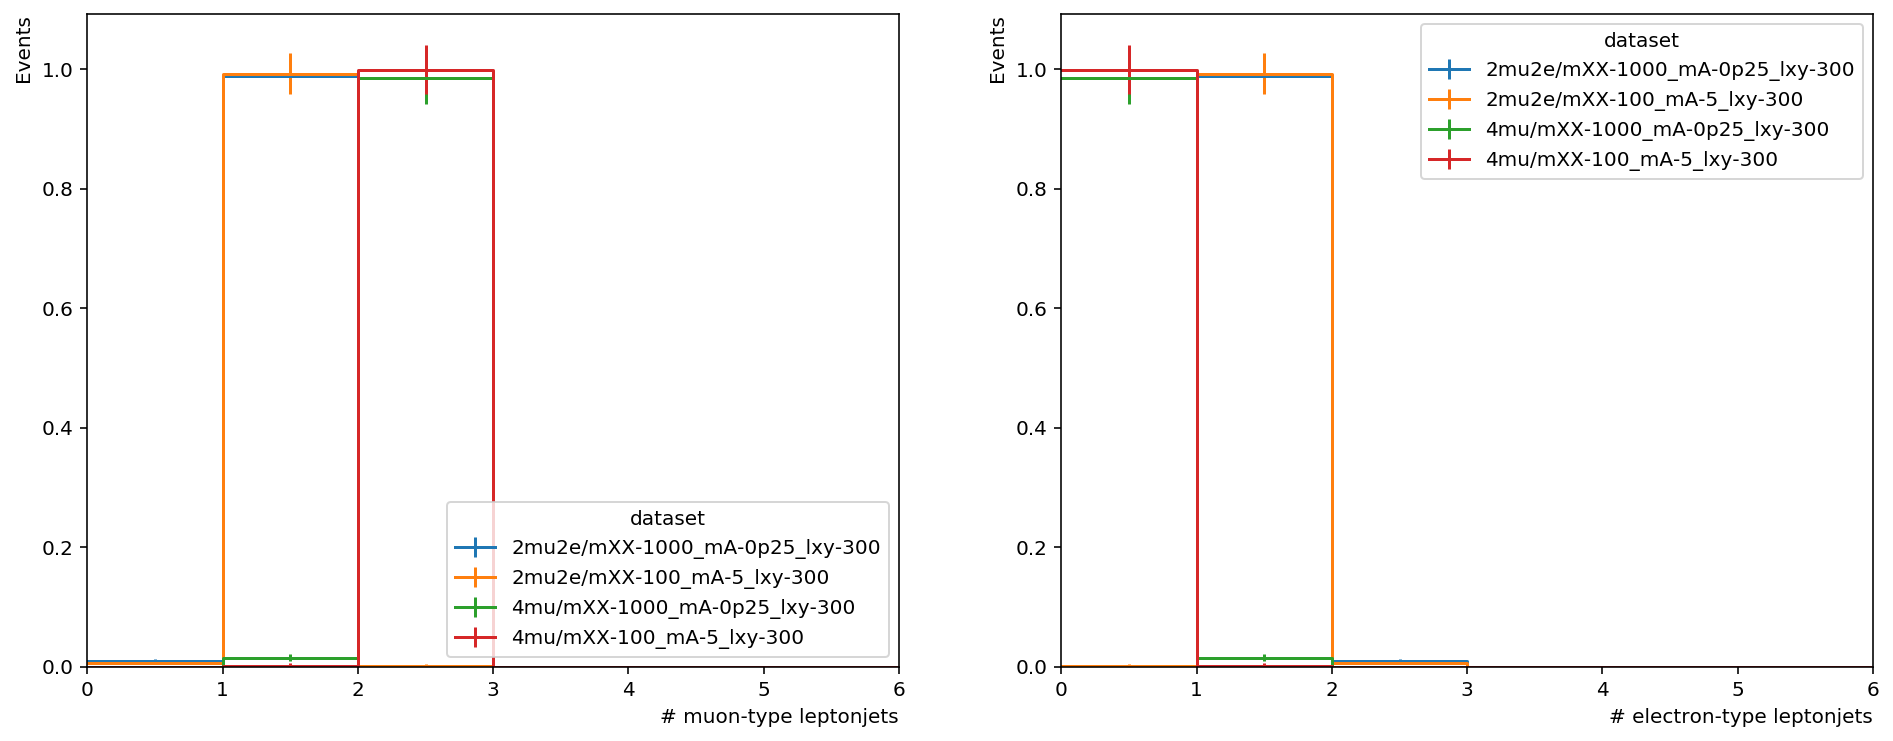

In [34]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['nmutype'], overlay='dataset', ax=axes[0], overflow='over', density=True)
hist.plot1d(output['neltype'], overlay='dataset', ax=axes[1], overflow='over', density=True)

for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

# Definition
Define:
- *mu-type*: leptonjets #mu>=2
- *el-type*: leptonjets #mu==0

Define:
- *4mu*: leading 2 are **mu-type** & exactly 2 **mu-type** leptonjets
- *2mu2e*: leading 2 are "1 **mu-type** + 1 **el-type**" & exactly 1 **mu-type** leptonjet

In [50]:
class invariantProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        m0_axis = hist.Bin('m0', 'mass [GeV]', 50, 0, 200)
        m1_axis = hist.Bin('m1', 'mass [GeV]', 50, 500, 1500)
        self._accumulator = processor.dict_accumulator({
            'm0': hist.Hist('Events', dataset_axis, m0_axis),
            'm1': hist.Hist('Events', dataset_axis, m1_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        leptonjets = leptonjets[leptonjets.counts>1]
        dileptonjets = leptonjets.distincts()
        leadingpair = dileptonjets[(dileptonjets.i0.pt+dileptonjets.i1.pt).argmax()]
        
        output['m0'].fill(dataset=dataset, m0=leadingpair.mass.flatten())
        output['m1'].fill(dataset=dataset, m1=leadingpair.mass.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- mXX: 100GeV

In [51]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=invariantProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:04<00:00,  4.98items/s]


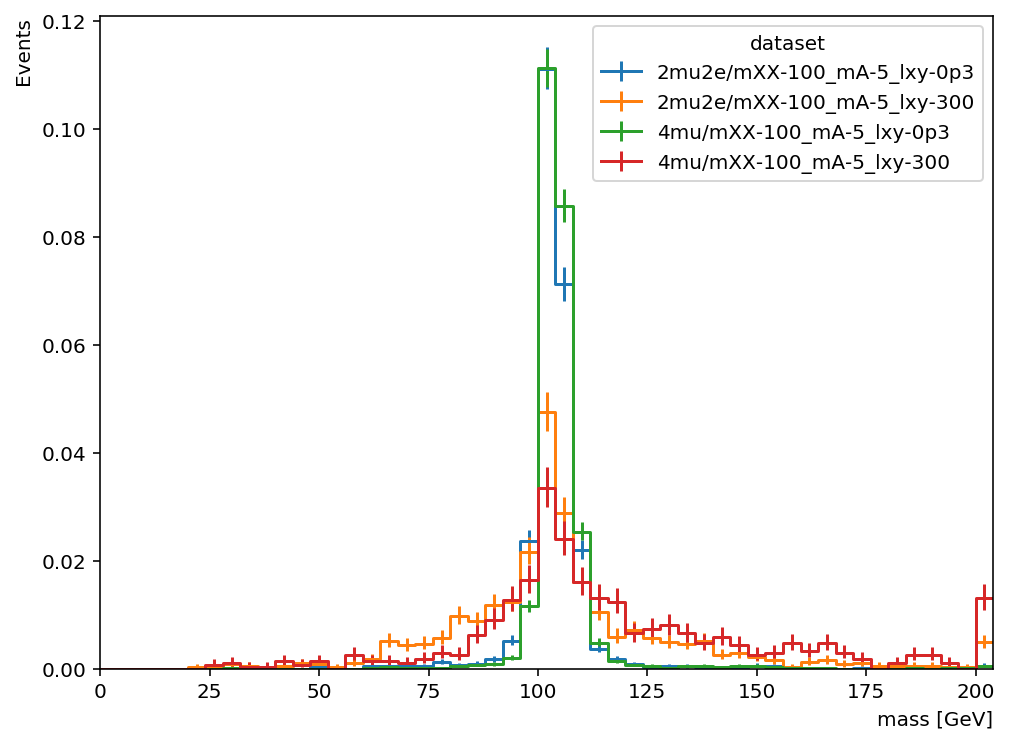

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot1d(output['m0'], overlay='dataset', overflow='over', ax=ax, density=True)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

- mXX: 1000 GeV

In [54]:
dataset={
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=invariantProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 20/20 [00:03<00:00,  6.64items/s]


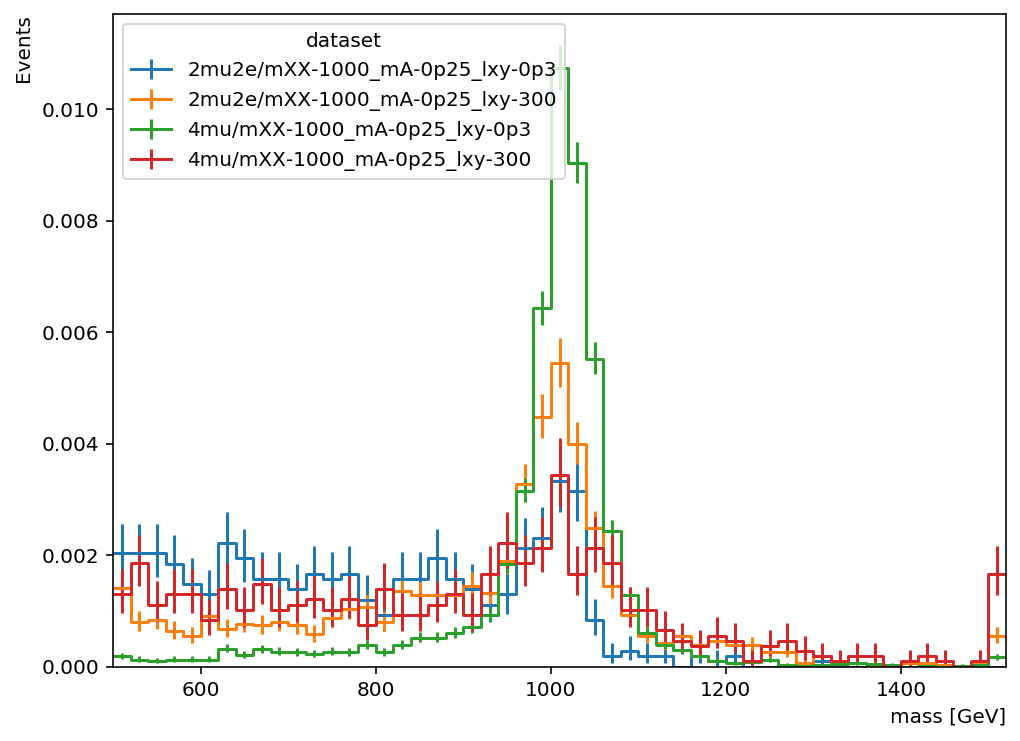

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot1d(output['m1'], overlay='dataset', overflow='over', ax=ax, density=True)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [71]:
class invariantProcessor4mu(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        m0_axis = hist.Bin('m0', 'mass [GeV]', 50, 0, 200)
        m1_axis = hist.Bin('m1', 'mass [GeV]', 50, 500, 1500)
        self._accumulator = processor.dict_accumulator({
            'm0': hist.Hist('Events', dataset_axis, m0_axis),
            'm1': hist.Hist('Events', dataset_axis, m1_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        leptonjets = leptonjets[leptonjets.counts>1]
        
        twomujets = leptonjets.ismutype.sum()==2
        
        dileptonjets = leptonjets.distincts()
        leadingpair = dileptonjets[(dileptonjets.i0.pt+dileptonjets.i1.pt).argmax()]
        bothmutype = leadingpair.i0.ismutype & leadingpair.i1.ismutype
        #print(bothmutype)
        eventselect = twomujets & bothmutype.flatten()
        
        output['m0'].fill(dataset=dataset, m0=leadingpair[eventselect].mass.flatten())
        output['m1'].fill(dataset=dataset, m1=leadingpair[eventselect].mass.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

    
class invariantProcessor2mu2e(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'dataset')
        m0_axis = hist.Bin('m0', 'mass [GeV]', 50, 0, 200)
        m1_axis = hist.Bin('m1', 'mass [GeV]', 50, 500, 1500)
        self._accumulator = processor.dict_accumulator({
            'm0': hist.Hist('Events', dataset_axis, m0_axis),
            'm1': hist.Hist('Events', dataset_axis, m1_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        leptonjets = leptonjets[leptonjets.counts>1]
        
        onemujets = leptonjets.ismutype.sum()==1
        
        dileptonjets = leptonjets.distincts()
        leadingpair = dileptonjets[(dileptonjets.i0.pt+dileptonjets.i1.pt).argmax()]
        onemutype = leadingpair.i0.ismutype | leadingpair.i1.ismutype
        eventselect = onemujets & onemutype.flatten()
        
        output['m0'].fill(dataset=dataset, m0=leadingpair[eventselect].mass.flatten())
        output['m1'].fill(dataset=dataset, m1=leadingpair[eventselect].mass.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

- mXX: 100GeV

In [69]:
dataset={
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    #'2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    #'2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=invariantProcessor4mu(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 10/10 [00:02<00:00,  4.99items/s]


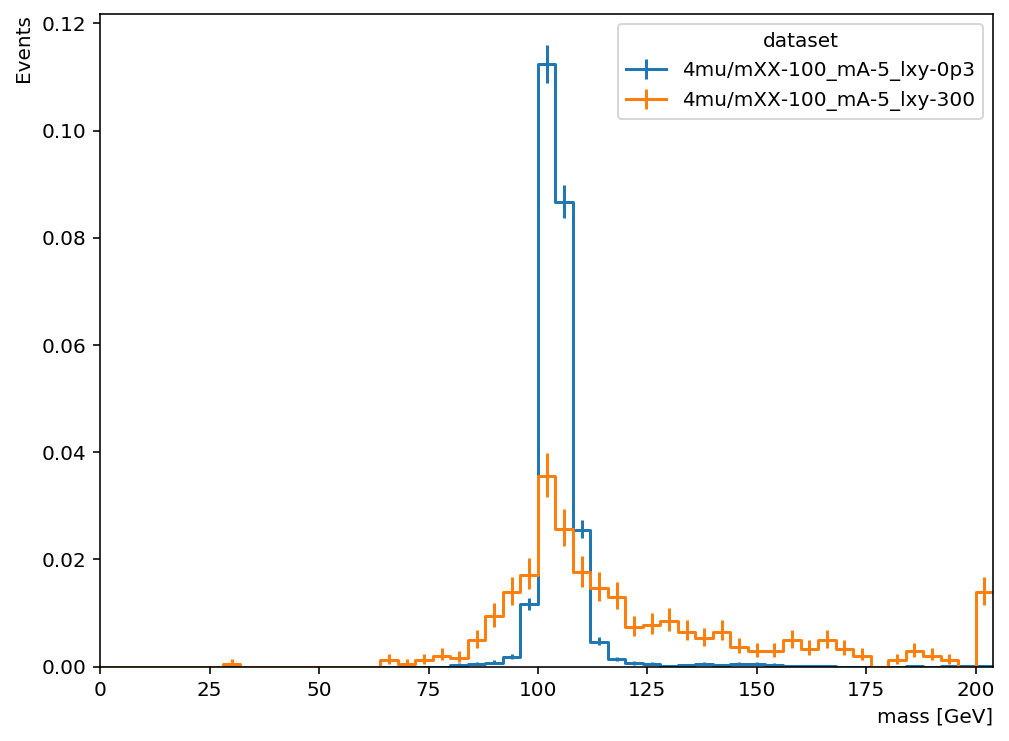

In [70]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot1d(output['m0'], overlay='dataset', overflow='over', ax=ax, density=True)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [72]:
dataset={
    #'4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    #'4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=invariantProcessor2mu2e(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 10/10 [00:02<00:00,  4.99items/s]


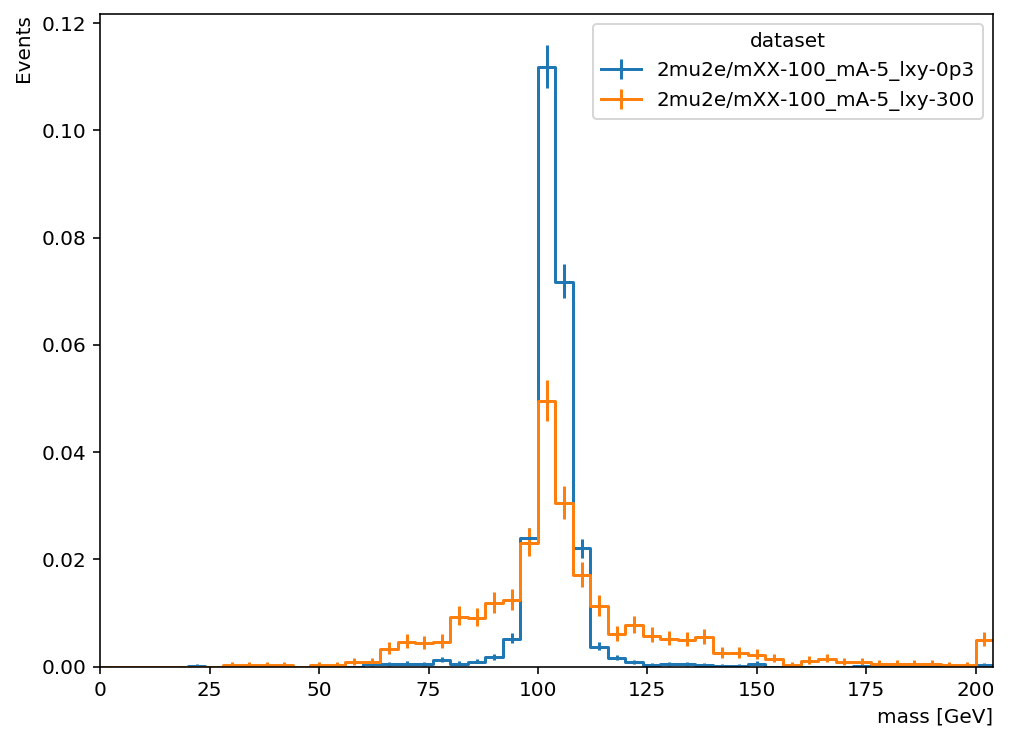

In [73]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot1d(output['m0'], overlay='dataset', overflow='over', ax=ax, density=True)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

- mXX: 1000 GeV

In [74]:
dataset={
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    #'2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    #'2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=invariantProcessor4mu(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 10/10 [00:07<00:00,  1.23items/s]


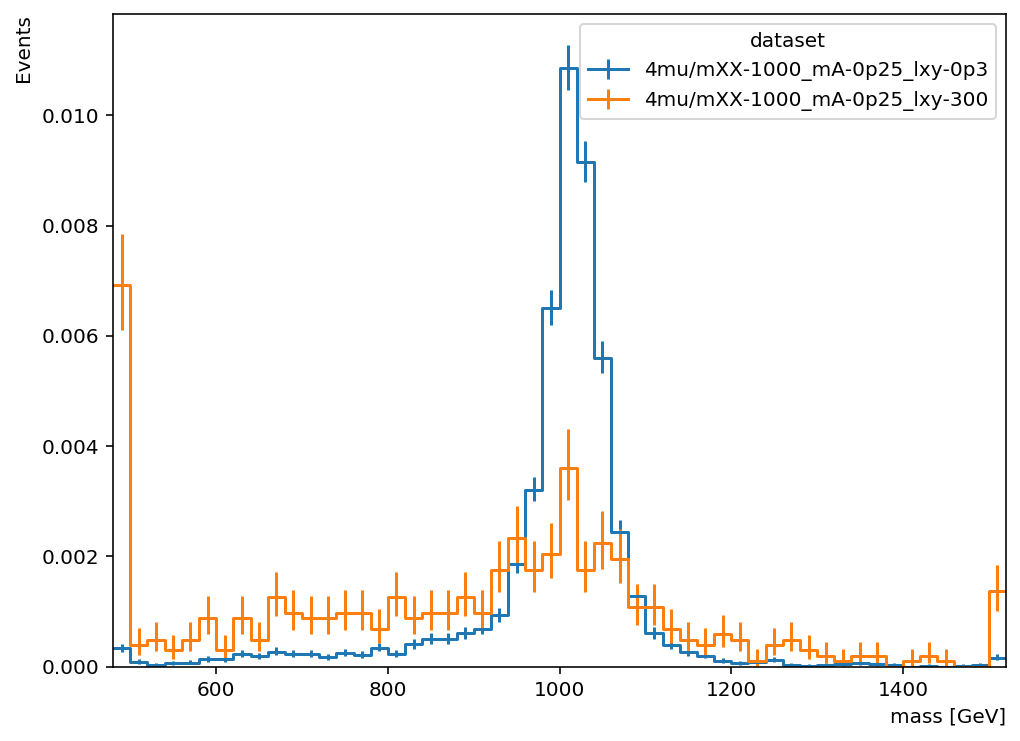

In [76]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot1d(output['m1'], overlay='dataset', overflow='all', ax=ax, density=True)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [77]:
dataset={
    #'4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
    #'4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=invariantProcessor2mu2e(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 10/10 [00:03<00:00,  1.66items/s]


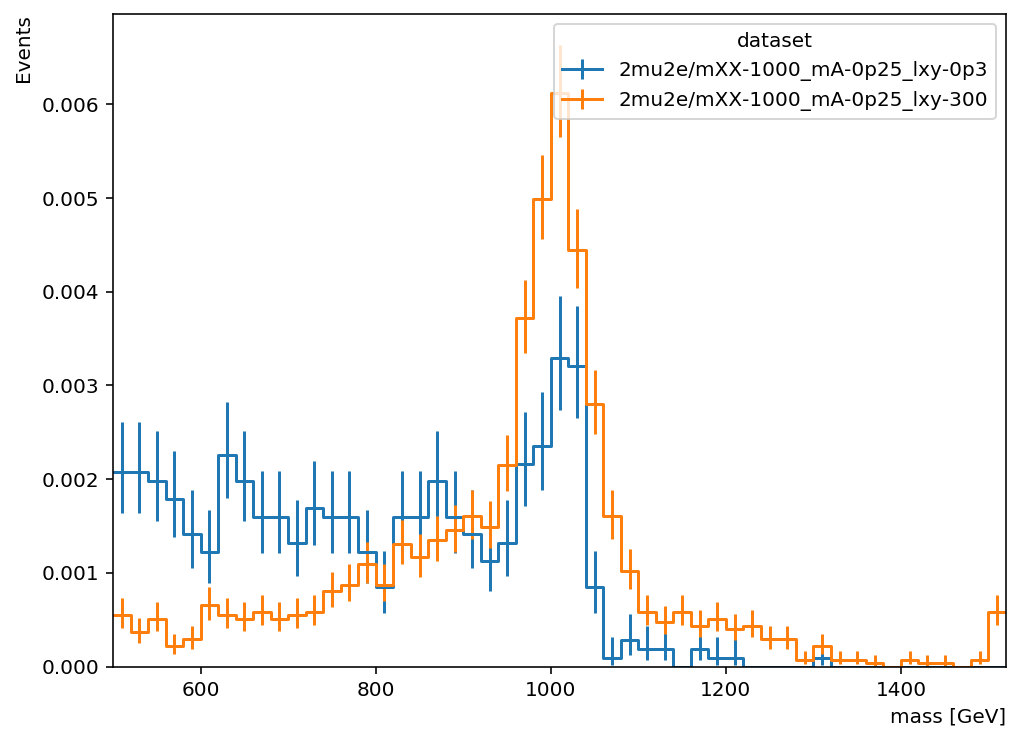

In [79]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot1d(output['m1'], overlay='dataset', overflow='over', ax=ax, density=True)
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");